In [14]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(RColorBrewer)
library(GGally)
library(broom)
library(readxl)
library(httr)
packageVersion("readxl")
options(repr.matrix.max.rows = 6)

[1] ‘1.4.0’

# Classifying the Knowledge Level of a Student

## Introduction
Accumulation of knowledge is an important part of education. However, one might wonder what would be the best way to gain knowledge? And what may affect one's knowledge level on a particular subject?

### Our question
How can we classify the knowledge level of a student with their study time, degree of repetition, and exam performace? Is there a more accurate way to classify the knowledge level with other parameters?

### Dataset
For our project, we will be using the User Knowledge Modeling Data Set, retrieved from https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling#. 

This data set contains data about the knowledge level of students on the subject of electrical DC machines, along with information about each students' study time, degree of repetition on the subject, study time on subjects related to this subject, the exam performance for subjects related to this subject, and exam performace for this subject. 

The data can be downloaded from going to the website and clicking "Data Folder". The data was downloaded, transformed into a csv file, and uploaded into the data folder for this project.

## Methods & Results

### Reading in file from the web into R

The file is found in:
https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls.

In this excel file, there are multiple sheets. We separate the training data in the second sheet into the object training_data and the testing data in the third sheet into the object testing_data respectively with the code below:

In [15]:
url1<- 'https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls'
p1f <- tempfile()
download.file(url1, p1f, mode="wb")

GET(url1, write_disk(tf <- tempfile(fileext = ".xls")))
training_data <- read_excel(tf, 2L)
testing_data <- read_excel(tf, 3L)


# This code reads the second and third sheet of the excel file. The idea of doing this in this fashion was found from stack overflow:
# https://stackoverflow.com/questions/41368628/read-excel-file-from-a-url-using-the-readxl-package

training_data <- select(training_data, STG:UNS)
testing_data <- select(testing_data,  STG:UNS)

# The code above selects the rows used in data analysis and removes excess meta information

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls]
  Date: 2022-11-30 02:11
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 57.9 kB
<ON DISK>  /tmp/Rtmp0BIJel/file5e474c4dd6.xlsNULL

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


## Cleaning and wrangling into tidy format

Here is what the first 5 rows of our training data look like:

In [16]:
slice(training_data, 1:5)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


From the source website, here is what the column labels mean: 

For each student,

STG: The degree of study time for subject

SCG: The degree of repetition for subject materials

STR: The degree of study time for related subjects

LPR: The exam performance for related subjects

PEG: The exam performance for subject

UNS: The knowledge level

Lets rename the columns for both sets of data to have better understanding:

In [17]:
training_data <- rename(training_data, 
                        direct_study_time = STG,
                        direct_repetition_degree = SCG,
                        related_study_time = STR,
                        related_exam_performance = LPR,
                        direct_exam_performance = PEG,
                        direct_knowledge_level = UNS)

testing_data <- rename(testing_data, 
                        direct_study_time = STG,
                        direct_repetition_degree = SCG,
                        related_study_time = STR,
                        related_exam_performance = LPR,
                        direct_exam_performance = PEG,
                        direct_knowledge_level = UNS)

In [18]:
slice(training_data, 1:5)

direct_study_time,direct_repetition_degree,related_study_time,related_exam_performance,direct_exam_performance,direct_knowledge_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


As we can see from our new table above, each row is a single observation, each column is a single variable, and each value is a single cell. Therefore, our data is tidy. Furthermore, our columns are more understandable and clear.

## Exploratory tables
### Mean of each numerical column

In [19]:
mean_values <- training_data %>%
  select(-direct_knowledge_level) %>%
  map_df(mean)
mean_values

direct_study_time,direct_repetition_degree,related_study_time,related_exam_performance,direct_exam_performance
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


### Number of each label in direct knowledge level


In [20]:
number_of_each_descriptor <- training_data %>%
  select(direct_knowledge_level) %>%
  group_by(direct_knowledge_level) %>%
  summarize(n = n())
number_of_each_descriptor

direct_knowledge_level,n
<chr>,<int>
High,63
Low,83
Middle,88
very_low,24


### Mean of each numerical column when grouped by knowledge level

In [21]:
mean_with_grouping <- training_data %>%
  group_by(direct_knowledge_level) %>%                                       #group by knowledge level
  summarize(across(direct_study_time:direct_exam_performance, mean)) %>%     #find mean of each numeric column
  arrange(direct_exam_performance)                                           #arrange rows from low to high                      
mean_with_grouping

direct_knowledge_level,direct_study_time,direct_repetition_degree,related_study_time,related_exam_performance,direct_exam_performance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
very_low,0.3057917,0.1981250,0.3662500,0.3587500,0.09083333
Low,0.3211446,0.3370000,0.4307229,0.4973494,0.23762651
Middle,0.3999773,0.3679205,0.5068182,0.3428409,0.54238636
High,0.4216508,0.4231905,0.5016667,0.5012698,0.77253968


## Exploratory Visualizations

### Distribution of some descriptors in knowledge level

Note: bars ordered by increasing number of occurences

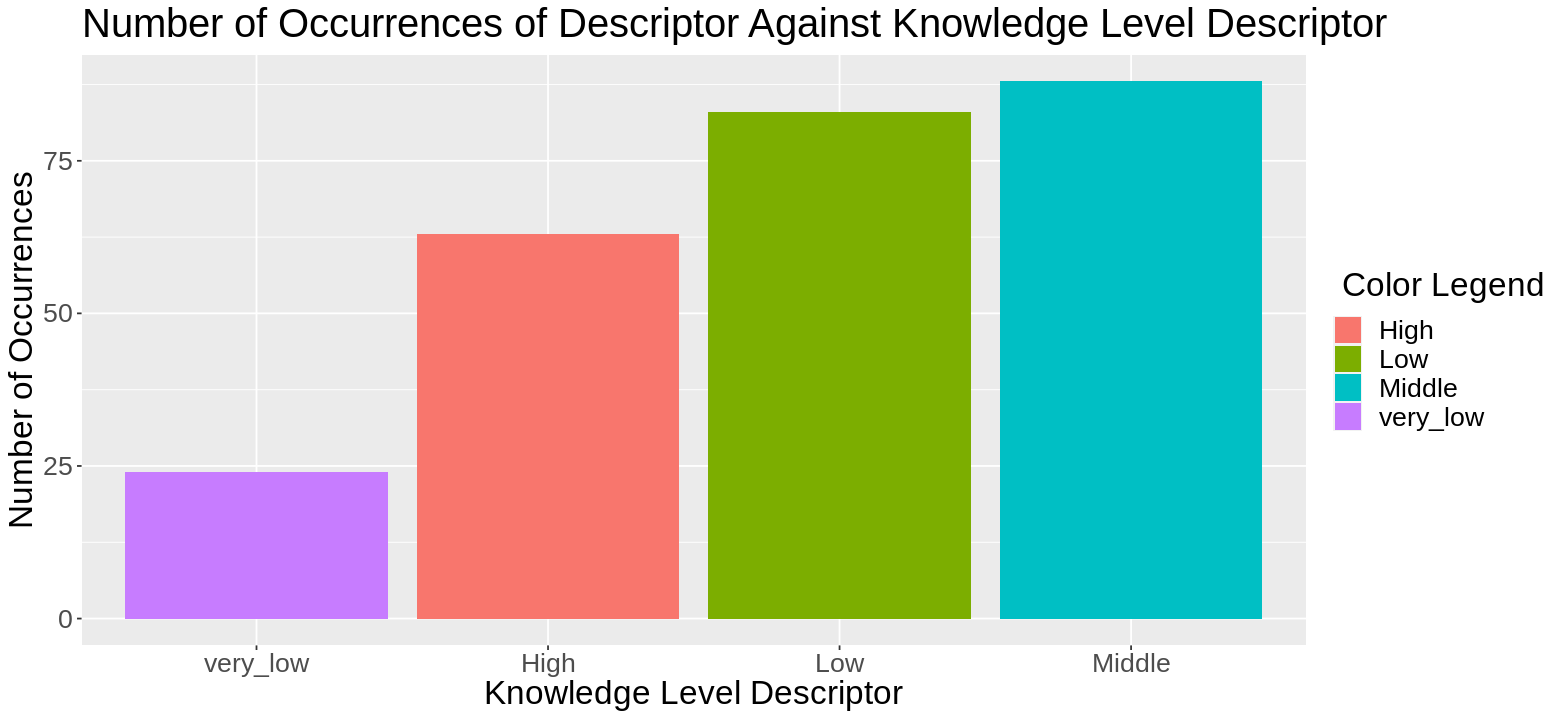

In [22]:
options(repr.plot.width = 13, repr.plot.height = 6)
distribution_of_descriptors_plot <- 
  ggplot(number_of_each_descriptor, aes(x = fct_reorder(direct_knowledge_level, n), y = n, fill = direct_knowledge_level)) +
  geom_bar(stat = "identity") + 
  ggtitle("Number of Occurrences of Descriptor Against Knowledge Level Descriptor") +
  labs(x = "Knowledge Level Descriptor", y = "Number of Occurrences", fill = " Color Legend") +
  theme(text = element_text(size = 20))  +
  scale_color_brewer(palette = "Set2")
distribution_of_descriptors_plot

### Distribution of means with knowledge level

Note: for all graphs below, bars are ordered by increasing means

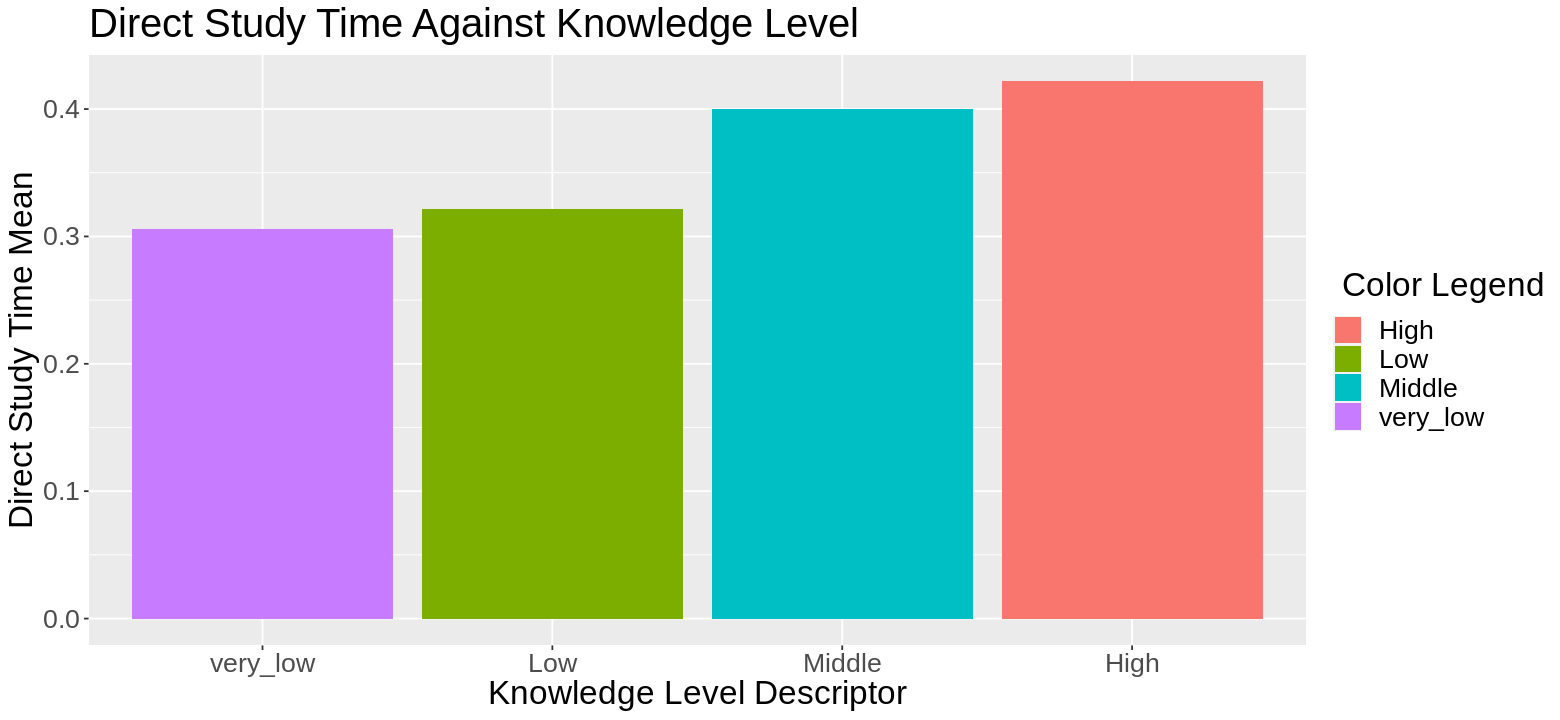

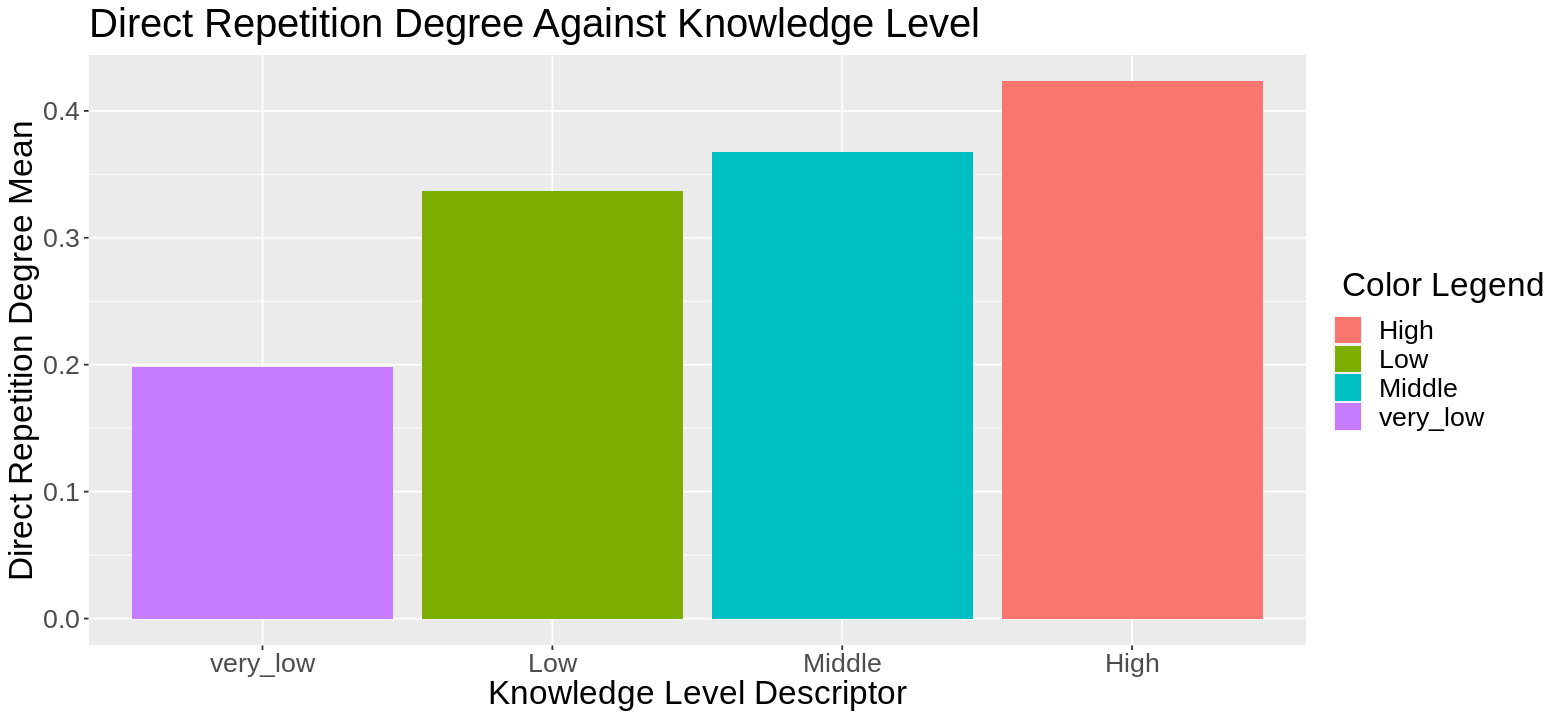

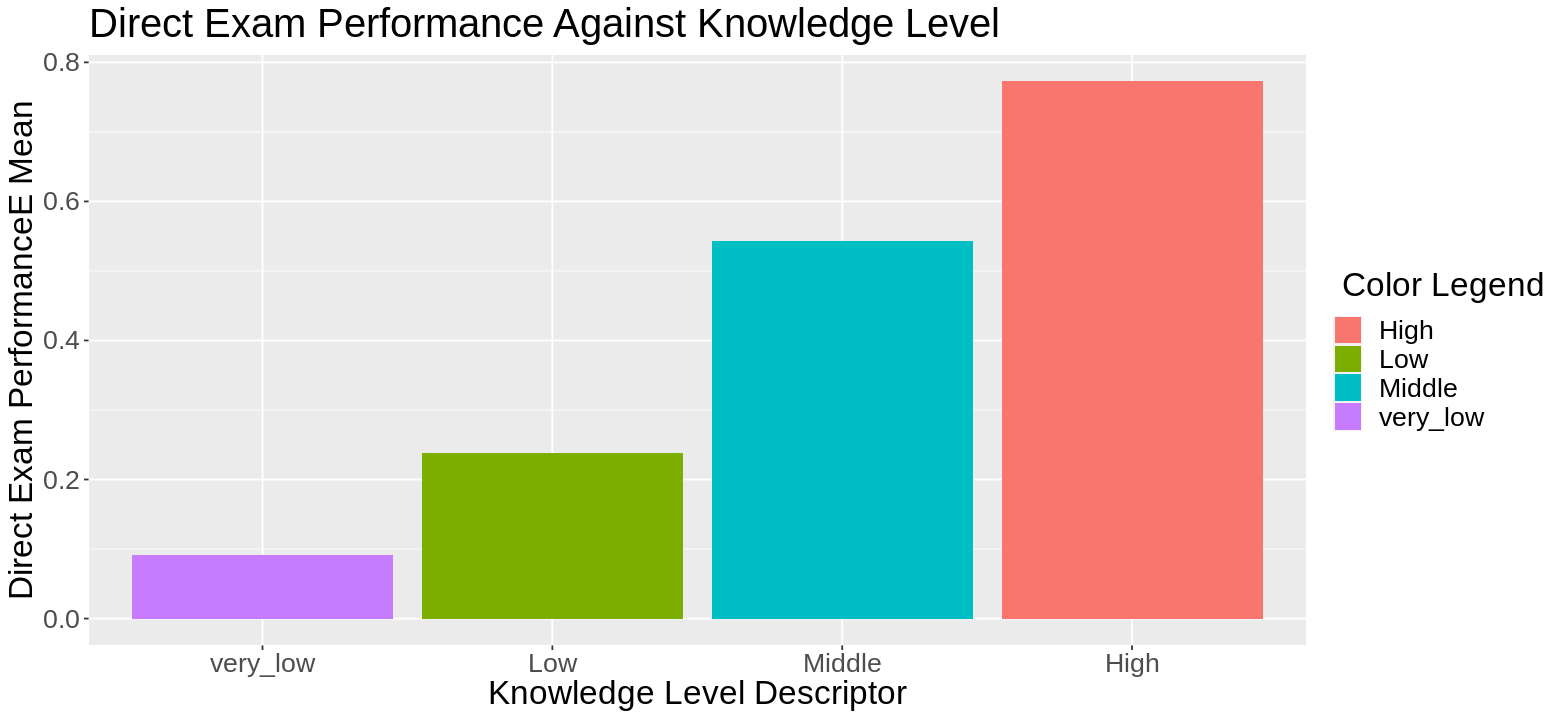

In [23]:
distribution_of_study_time_plot <-
  ggplot(mean_with_grouping, aes(x = fct_reorder(direct_knowledge_level, direct_study_time), y = direct_study_time, fill = direct_knowledge_level)) +
  geom_bar(stat = "identity") + 
  ggtitle("Direct Study Time Against Knowledge Level") +
  labs(x = "Knowledge Level Descriptor", y = "Direct Study Time Mean", fill = " Color Legend") +
  theme(text = element_text(size = 20))  +
  scale_color_brewer(palette = "Set2")
distribution_of_study_time_plot

distribution_of_repetition_plot <-
  ggplot(mean_with_grouping, aes(x = fct_reorder(direct_knowledge_level, direct_repetition_degree), y = direct_repetition_degree, fill = direct_knowledge_level)) +
  geom_bar(stat = "identity") + 
  ggtitle("Direct Repetition Degree Against Knowledge Level") +
  labs(x = "Knowledge Level Descriptor", y = "Direct Repetition Degree Mean", fill = " Color Legend") +
  theme(text = element_text(size = 20))  +
  scale_color_brewer(palette = "Set2")
distribution_of_repetition_plot

distribution_of_exam_performance_plot <-
  ggplot(mean_with_grouping, aes(x = fct_reorder(direct_knowledge_level, direct_exam_performance), y = direct_exam_performance, fill = direct_knowledge_level)) +
  geom_bar(stat = "identity") + 
  ggtitle("Direct Exam Performance Against Knowledge Level") +
  labs(x = "Knowledge Level Descriptor", y = "Direct Exam PerformanceE Mean", fill = " Color Legend") +
  theme(text = element_text(size = 20))  +
  scale_color_brewer(palette = "Set2")
distribution_of_exam_performance_plot

## Methods
For our data analysis, we will use the closest k points method with the direct study time, repetition degree, and direct exam performance to classify knowledge levels. We will try to find the best value for k, and see how accurate our model is when tested. One way we will visualize the result is by showing a graph of accuracy against k. This will show clearly the best value for k. We will also try other combinations of columns, such as just direct exam performance and direct repetition degree, or using related study time and direct study time. We can plot the different accurcies with each combination of columns with a bar graph to visualize how each combination affects the accuracy. 

## Expected outcomes and significance


#### Expected findings:
From our plots above, we can tell that there is a correlation between high direct study time, repetition degree, and direct exam results with higher knowledge levels. Therefore, we expect our accuracy to be moderately high. We also expect the most accurate plot to be with our three chosen variables, as they are logically most related to the subject at hand.

#### Impact of our finding:
Our findings may show what affects knowledge level the most. It could bring to light the most important aspects of effective studying. As a result, knowing which factors are most important can greatly improve learning efficiency. This also helps to save time throughout the day to maximize productivity.

#### Future questions:
1.What other variables may affect user knoweldge? 

2.Are there more important variables than the ones we have?